# Age stuctured sturgeon model
## Trasnient response to perturbation

This note book plots the ifluence fucntions and equilbrium diagrams for the age structured sturgeon model. It will also examine the behavior of the model linearized around the equilibrium abundace to understand the impacts of perterbations.   

In [ ]:
import Pkg
Pkg.add("Roots")
include("age_structure_model.jl")
include("fecundity_at_age.jl")
include("full_trait_distribution.jl")
using LinearAlgebra
using Plots
using Roots
using Distributions

## Define paramters for age structured dynamics

In [220]:
# single paramters 
A_max = 100 # max age
A_mature = 0 # age at maturity 
f_infty = 10.0^6 # maximum fecundity 
k = 0.1 # growth rate 
a0 = 5.0 # growth paramter
s = 0.8 # survival rate


# vectorized paramters
fecundity = broadcast(x -> fecundity_at_age.isometric_LVB(x,f_infty,k,a0), 1:A_max)
survival = repeat([s],A_max)

A = age_structure_model.build_age_matrix(A_max,fecundity,survival)
print(" ")

## Influence function

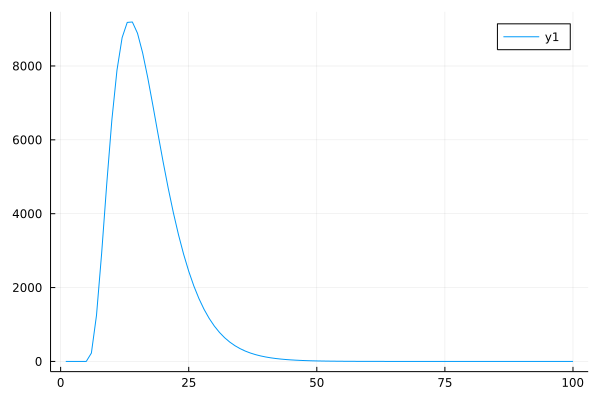

In [221]:
survived = zeros(length(survival))

for i in 1:length(survival)
    survived[i] = prod(survival[1:i])
end
Plots.plot(fecundity.*survived .* collect(1:A_max .> A_mature))

## Expected life time egg production 

In [222]:
LEP = age_structure_model.LEP(1.0, survival, fecundity, A_max )

153968.56632786052

## Density dependent survival 

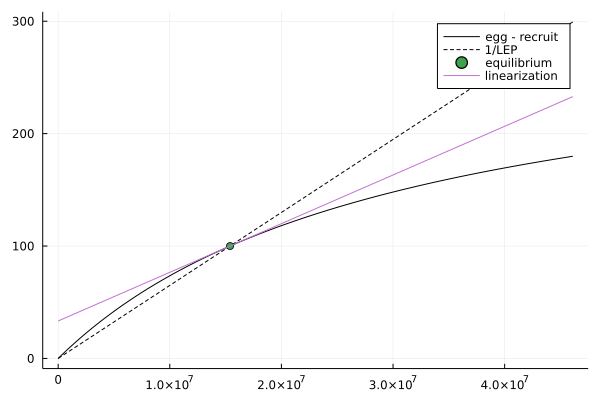

In [223]:
r = 1.5
K = 300
e_max = K*LEP
a = r/LEP
b = a/K
F(x,a,b) = a*x/(1+b*x)
f = x -> F(x,a,b) 
g = x -> F(x,a,b) - x/LEP
x = 0:10^5:e_max
Plots.plot(x, f.(x), color = "black", label = "egg - recruit")
Plots.plot!(x, x./LEP, color = "black", linestyle = :dash, label = "1/LEP")
x_eq = Roots.find_zero(g, (1, e_max))
y_eq = f(x_eq)
Plots.scatter!([x_eq],[y_eq], label = "equilibrium")
Plots.plot!(x,x./(a*LEP^2) .+(f(x_eq)-x_eq/(a*LEP^2)) , label = "linearization")

## Eigen value analysis 
The first three eigen values characterize the transient dynamics of the population to perterbations. One minus the first eigen value describes the resiliance of the system and the second two eigen vlaues describe the strength of oscilaitons caused by the perturbation and its interaciton with the age structure of the popuation. 

In [224]:
J = age_structure_model.build_age_matrix(A_max,fecundity .* 1/(a*LEP^2),survival)
vals = eigen(J)
vals.values[end-2:end]

3-element Vector{ComplexF64}:
 0.8006890808568573 - 0.06349290999431101im
 0.8006890808568573 + 0.06349290999431101im
 0.9768787191549411 + 0.0im

## reactivity

In [225]:
J = age_structure_model.build_age_matrix(A_max,fecundity .* 1/(a*LEP^2),survival)
vals = eigen((J.+transpose(J))./2)
vals.values[end-2:end]

3-element Vector{Float64}:
  0.7965227819190279
  0.7984841917249246
 18.648372809696834

## Simulations with genetic effects
### parameters

In [226]:
min = -7.5
max = 15
dx = 0.1
grid = min:dx:max

s = 0.1
theta = 0
theta_1 = 10.0
Vle = 1.0
gradient = exp.(-s/2*(grid .- theta).^2)
d = Distributions.Normal(theta_1,sqrt(Vle))
dsn_im = pdf.(d,grid)
dsn_im = dsn_im ./ sum(dsn_im)
print(" ")


### correction for stabalizing selection

In [227]:
h(x) = 0.5/(1/x+s) + 0.5*Vle - x
Veq = Roots.find_zero(h, (0,2*Vle))
d = Distributions.Normal(theta,sqrt(Veq))
dsn = pdf.(d,grid)
dsn = dsn ./ sum(dsn)
adj = sum(dsn.*gradient)

0.9568548076785355

### define population and dynamics

In [228]:
pop = full_trait_distribution.init_population(A_max, survival, fecundity, r ,K, theta, s, min, max, dx, Vle)

function update!(pop, R_im)

    # reproduction
    dsn, F = full_trait_distribution.reproduction(pop)
    

    # seleciton
    dsn, R = full_trait_distribution.selection(dsn, F, pop)
    R = R/adj
    # immigration
    dsn, R = full_trait_distribution.immigration(dsn, R, dsn_im, R_im*R)
    # dentisy dependence
    R = full_trait_distribution.recruitment(R, pop)
    # ageing!
    pop = full_trait_distribution.ageing!(pop, R, dsn)
    return pop
end

153968.56632786052

update! (generic function with 1 method)

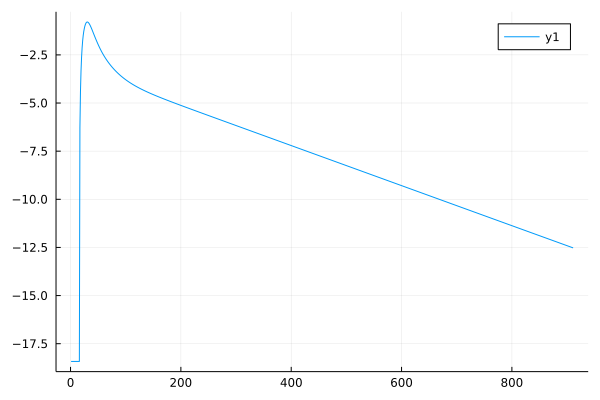

In [229]:
N = 1000
R_im = vcat(repeat([0],N), repeat([1.0],10), repeat([0],N))

n = zeros(2*N)
f = zeros(2*N)
W = zeros(2*N)
#Plots.plot(pop.trait[:,1])
for i in 1:2*N
    update!(pop, R_im[i])
    n[i] = sum(pop.abundance[1])
    f[i] = sum((pop.gradient.*pop.trait ) * (pop.abundance .* pop.fecundity) )/sum(pop.abundance .* pop.fecundity) / adj
    W[i] = full_trait_distribution.fittness(pop)
end 
#Plots.plot(n./n[1])
Plots.plot( log.(1.00000001 .- W[990:1900]./W[990]))

0.7745193177020043